In [1]:
# import problems
import sys

sys.path.append("C:\Python311\Lib\site-packages")

In [3]:
%load_ext lab_black
import pandas as pd
from IPython.display import JSON
import warnings
import ast
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pivottablejs import pivot_ui

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    mean_squared_error,
    confusion_matrix,
    classification_report,
)
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

import sweetviz as sv

warnings.filterwarnings("ignore")

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [25]:
df = pd.read_csv("world_cup_2022_catar.csv")
df.shape

(64, 25)

In [26]:
df.head(1)

,stage,date,pens,pens_home_score,pens_away_score,team_name_home,team_name_away,team_home_score,team_away_score,possession_home,...,duels_won_home,duels_won_away,prediction_team_home_win,prediction_draw,prediction_team_away_win,prediction_quantity,location,events_list,lineup_home,lineup_away
0,Final,18/12/2022,True,4,2,Argentina,France,3,3,54%,...,40%,60%,64%,3%,33%,1002332,Lusail Iconic Stadium,"[{'event_team': 'home', 'event_time': "" 23' "",...","[{'player_name': ' Di María ', 'player_number'...","[{'player_name': ' Giroud ', 'player_number': ..."


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   stage                     64 non-null     object
 1   date                      64 non-null     object
 2   pens                      64 non-null     bool  
 3   pens_home_score           64 non-null     object
 4   pens_away_score           64 non-null     object
 5   team_name_home            64 non-null     object
 6   team_name_away            64 non-null     object
 7   team_home_score           64 non-null     int64 
 8   team_away_score           64 non-null     int64 
 9   possession_home           64 non-null     object
 10  possession_away           64 non-null     object
 11  total_shots_home          64 non-null     int64 
 12  total_shots_away          64 non-null     int64 
 13  shots_on_target_home      64 non-null     int64 
 14  shots_on_target_away      64

In [28]:
df.describe()

,team_home_score,team_away_score,total_shots_home,total_shots_away,shots_on_target_home,shots_on_target_away,prediction_quantity
count,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,6.400000e+01
mean,1.578125,1.109375,11.296875,11.453125,4.312500,3.765625,4.036118e+05
std,1.551289,1.055856,5.088673,5.866043,2.617857,2.729860,2.001993e+05
min,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,1.304210e+05
25%,0.000000,0.000000,8.000000,7.750000,3.000000,2.000000,2.321788e+05
50%,1.000000,1.000000,10.500000,10.500000,4.000000,3.000000,3.639255e+05
75%,2.000000,2.000000,14.000000,14.000000,6.000000,5.000000,5.351200e+05
max,7.000000,4.000000,26.000000,32.000000,10.000000,12.000000,1.002332e+06


In [29]:
df.columns

Index(['stage', 'date', 'pens', 'pens_home_score', 'pens_away_score',
       'team_name_home', 'team_name_away', 'team_home_score',
       'team_away_score', 'possession_home', 'possession_away',
       'total_shots_home', 'total_shots_away', 'shots_on_target_home',
       'shots_on_target_away', 'duels_won_home', 'duels_won_away',
       'prediction_team_home_win', 'prediction_draw',
       'prediction_team_away_win', 'prediction_quantity', 'location',
       'events_list', 'lineup_home', 'lineup_away'],
      dtype='object')

### Changing porcentage dtype to be used later (Data transformation)

In [30]:
def clean_percentage_columns(df, columns_list):
    for column in columns_list:
        df[column] = df[column].astype(str)
        df[column] = df[column].str.replace("%", "")
        df[column] = df[column].astype(float)
        df[column] = df[column] / 100
    return df

In [31]:
clean_percentage_columns(
    df,
    [
        "possession_home",
        "possession_away",
        "duels_won_home",
        "duels_won_away",
        "prediction_team_home_win",
        "prediction_draw",
        "prediction_team_away_win",
        "prediction_quantity",
    ],
)

,stage,date,pens,pens_home_score,pens_away_score,team_name_home,team_name_away,team_home_score,team_away_score,possession_home,...,duels_won_home,duels_won_away,prediction_team_home_win,prediction_draw,prediction_team_away_win,prediction_quantity,location,events_list,lineup_home,lineup_away
0,Final,18/12/2022,True,4,2,Argentina,France,3,3,0.54,...,0.40,0.60,0.64,0.03,0.33,10023.32,Lusail Iconic Stadium,"[{'event_team': 'home', 'event_time': "" 23' "",...","[{'player_name': ' Di María ', 'player_number'...","[{'player_name': ' Giroud ', 'player_number': ..."
1,Match for third place,17/12/2022,False,False,False,Croatia,Morocco,2,1,0.51,...,0.53,0.47,0.42,0.04,0.54,3671.56,Khalifa International Stadium,"[{'event_team': 'home', 'event_time': "" 7' "", ...","[{'player_name': ' Livaja ', 'player_number': ...","[{'player_name': ' Boufal ', 'player_number': ..."
2,Semi-finals,14/12/2022,False,False,False,France,Morocco,2,0,0.38,...,0.58,0.42,0.58,0.03,0.39,7207.68,Al Bayt Stadium,"[{'event_team': 'home', 'event_time': "" 5' "", ...","[{'player_name': ' Giroud ', 'player_number': ...","[{'player_name': ' En-Nesyri ', 'player_number..."
3,Semi-finals,13/12/2022,False,False,False,Argentina,Croatia,3,0,0.39,...,0.43,0.57,0.71,0.04,0.25,7923.26,Lusail Iconic Stadium,"[{'event_team': 'away', 'event_time': "" 32' "",...","[{'player_name': ' Álvarez ', 'player_number':...","[{'player_name': ' Perišić ', 'player_number':..."
4,Quarter-finals,10/12/2022,False,False,False,England,France,1,2,0.58,...,0.55,0.45,0.40,0.05,0.55,6725.77,Al Bayt Stadium,"[{'event_team': 'away', 'event_time': "" 17' "",...","[{'player_name': ' Foden ', 'player_number': '...","[{'player_name': ' Giroud ', 'player_number': ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,Group stage: Matchday 1,22/11/2022,False,False,False,Argentina,Saudi Arabia,1,2,0.70,...,0.64,0.36,0.94,0.02,0.04,6573.83,Lusail Iconic Stadium,"[{'event_team': 'home', 'event_time': "" 10' "",...","[{'player_name': ' Martínez ', 'player_number'...","[{'player_name': ' Al-Shehri ', 'player_number..."
60,Group stage: Matchday 1,21/11/2022,False,False,False,USA,Wales,1,1,0.59,...,0.47,0.54,0.51,0.09,0.40,3611.45,Ahmad bin Ali Stadium,"[{'event_team': 'home', 'event_time': "" 11' "",...","[{'player_name': ' Pulisic ', 'player_number':...","[{'player_name': ' James ', 'player_number': '..."
61,Group stage: Matchday 1,21/11/2022,False,False,False,Senegal,Netherlands,0,2,0.46,...,0.54,0.47,0.22,0.07,0.71,4579.77,Al Thumama Stadium,"[{'event_team': 'away', 'event_time': "" 56' "",...","[{'player_name': ' Dia ', 'player_number': ' 9...","[{'player_name': ' Bergwijn ', 'player_number'..."
62,Group stage: Matchday 1,21/11/2022,False,False,False,England,Iran,6,2,0.79,...,0.60,0.40,0.92,0.02,0.06,4987.52,Khalifa International Stadium,"[{'event_team': 'away', 'event_time': "" 20' "",...","[{'player_name': ' Kane ', 'player_number': ' ...","[{'player_name': ' Taremi ', 'player_number': ..."


### EDA (SweetViz)

In [163]:
my_report = sv.analyze(df)
my_report.show_html()

Done! Use 'show' commands to display/save.   |██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| [100%]   00:01 -> (00:00 left)


Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


#### Correlation Matrix

<AxesSubplot: >

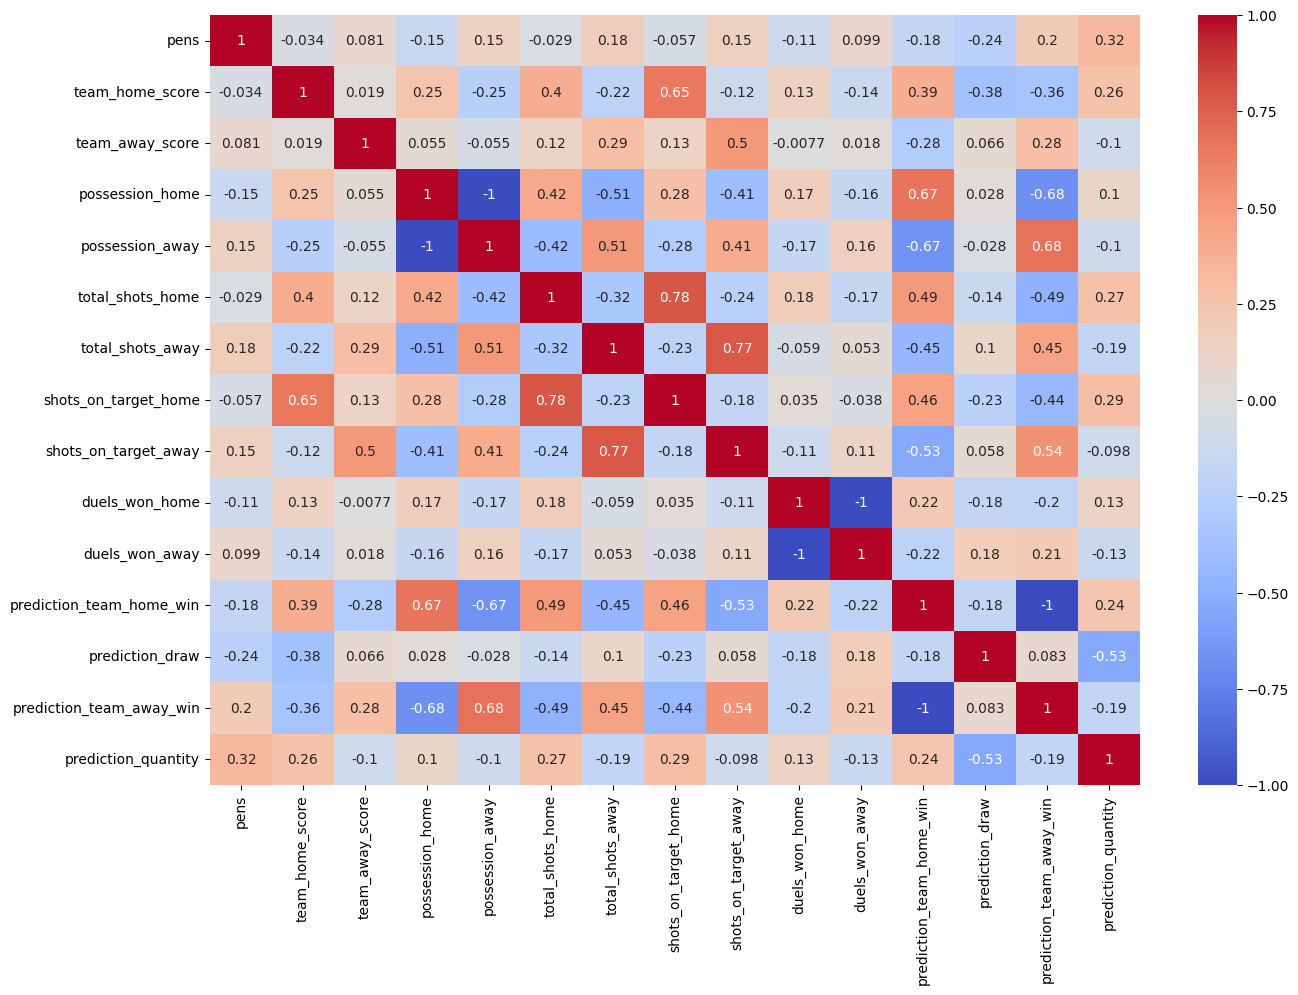

In [45]:
corr = df.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr, annot=True, cmap="coolwarm")

In [47]:
threshold = 0.8
correlated_columns = corr.loc[abs(corr) > threshold]

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\caio_barros\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py", line 3378, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\caio_barros\AppData\Local\Temp\ipykernel_7632\1920372324.py", line 2, in <module>
    correlated_columns = corr.loc[abs(corr) > threshold]
  File "C:\Users\caio_barros\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py", line 967, in __getitem__
    return self._getitem_axis(maybe_callable, axis=axis)
  File "C:\Users\caio_barros\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py", line 1189, in _getitem_axis
    raise ValueError("Cannot index with multidimensional key")
ValueError: Cannot index with multidimensional key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\caio_barros\AppData\Local\Programs\Python

In [39]:
# Identify columns with a correlation coefficient higher than a threshold value
threshold = 0.8
correlated_columns = set()
for i in range(len(corr.columns)):
    for j in range(i):
        if abs(corr.iloc[i, j]) > threshold:
            colname = corr.columns[i]
            correlated_columns.add(colname)

In [40]:
correlated_columns

{'duels_won_away', 'possession_away', 'prediction_team_away_win'}

### Manipulating events_list, lineup_home and lineup_away columns into new columns

#### lineup_home manipulation

In [10]:
df["lineup_home"] = df["lineup_home"].str.replace("'", '"')
df["lineup_home"] = df["lineup_home"].apply(json.loads)

# transforming lineup_home list of dictionaries into new columns
def extract_player_data(lineup):
    if not lineup or not isinstance(lineup, list):
        return None, None
    player_names = [
        player["player_name"] for player in lineup if isinstance(player, dict)
    ]
    player_numbers = [
        player["player_number"] for player in lineup if isinstance(player, dict)
    ]
    if len(player_names) != len(player_numbers):
        print(lineup)
        return None, None
    return (player_names, player_numbers)


df["player_names_home"] = df.apply(
    lambda row: extract_player_data(row["lineup_home"])[0], axis=1
)
df["player_numbers_home"] = df.apply(
    lambda row: extract_player_data(row["lineup_home"])[1], axis=1
)

# retirar o espaçamento entre os valores
df["player_names_home"] = df["player_names_home"].apply(
    lambda x: list(map(str.strip, x))
)
df["player_numbers_home"] = df["player_numbers_home"].apply(
    lambda x: list(map(str.strip, x))
)
df.drop("lineup_home", axis=1, inplace=True)

#### lineup_away manipulation

In [11]:
df["lineup_away"] = df["lineup_away"].str.replace("'", '"')
df["lineup_away"] = df["lineup_away"].apply(json.loads)

# transforming lineup_away list of dictionaries into new columns
def extract_player_data(lineup):

    if not lineup or not isinstance(lineup, list):
        return None, None
    player_names = [
        player["player_name"] for player in lineup if isinstance(player, dict)
    ]
    player_numbers = [
        player["player_number"] for player in lineup if isinstance(player, dict)
    ]
    if len(player_names) != len(player_numbers):
        print(lineup)
        return None, None
    return (player_names, player_numbers)


df["player_names_away"] = df.apply(
    lambda row: extract_player_data(row["lineup_away"])[0], axis=1
)
df["player_numbers_away"] = df.apply(
    lambda row: extract_player_data(row["lineup_away"])[1], axis=1
)

# retirar o espaçamento entre os valores
df["player_names_away"] = df["player_names_away"].apply(
    lambda x: list(map(str.strip, x))
)
df["player_numbers_away"] = df["player_numbers_away"].apply(
    lambda x: list(map(str.strip, x))
)

df.drop("lineup_away", axis=1, inplace=True)

#### events_list manipulation

In [12]:
# getting the values from "events_list" columns and transforming to another dataframe.
df_events_list = pd.DataFrame(
    columns=[
        "team",
        "event_team",
        "event_time",
        "event_type",
        "action_player_1",
        "action_player_2",
    ]
)

for i, row in df.iterrows():
    events_list = ast.literal_eval(row["events_list"])
    for event in events_list:
        if event.get("event_team") == "home":
            team = row.team_name_home
        else:
            team = row.team_name_away
        df_events_list = df_events_list.append(
            {
                "team": team,
                "event_team": event.get("event_team"),
                "event_time": event.get("event_time"),
                "event_type": event.get("event_type"),
                "action_player_1": event.get("action_player_1"),
                "action_player_2": event.get("action_player_2"),
            },
            ignore_index=True,
        )

df.drop("events_list", axis=1, inplace=True)

In [13]:
df_events_list

,team,event_team,event_time,event_type,action_player_1,action_player_2
0,Argentina,home,23',Penalty,Lionel Messi,Penalty
1,Argentina,home,36',Goal,Ángel Di María,Alexis Mac Allister
2,France,away,41',Substitution,Randal Kolo Muani,Ousmane Dembélé
3,France,away,41',Substitution,Marcus Thuram,Olivier Giroud
4,Argentina,home,52',Yellow card,Enzo Fernández,None
...,...,...,...,...,...,...
1038,Qatar,home,72',Substitution,Mohammed Muntari,Almoez Ali
1039,Ecuador,away,77',Substitution,José Cifuentes,Enner Valencia
1040,Qatar,home,78',Yellow card,Akram Afif,None
1041,Ecuador,away,90',Substitution,Kevin Rodríguez,Michael Estrada


In [14]:
# df_events_list.to_csv("datasets/df_events_list.csv", index=False)

#### Creating some statistics

In [15]:
df_global_statistics = (
    df_events_list.event_type.value_counts()
    .to_frame()
    .reset_index()
    .rename({"index": "event_type", "event_type": "total"}, axis=1)
)
# df_global_statistics.to_csv("datasets/df_global_statistics.csv", index=False)
df_global_statistics

,event_type,total
0,Substitution,587
1,Yellow card,224
2,Goal,153
3,PK,41
4,Penalty,17
5,Disallowed goal,9
6,Missed penalty,6
7,Second yellow card,3
8,Own goal,2
9,Red card,1


In [16]:
df_events_list.event_type.value_counts()

Substitution          587
Yellow card           224
Goal                  153
PK                     41
Penalty                17
Disallowed goal         9
Missed penalty          6
Second yellow card      3
Own goal                2
Red card                1
Name: event_type, dtype: int64

In [17]:
df_players_goals = df_events_list[
    (df_events_list.event_type == "Goal")
    | (df_events_list.event_type == "Penalty")
    | (df_events_list.event_type == "Own goal")
]
# df_players_goals.to_csv("datasets/df_players_goals.csv", index=False)
df_players_goals

,team,event_team,event_time,event_type,action_player_1,action_player_2
0,Argentina,home,23',Penalty,Lionel Messi,Penalty
1,Argentina,home,36',Goal,Ángel Di María,Alexis Mac Allister
9,France,away,80',Penalty,Kylian Mbappé,Penalty
10,France,away,81',Goal,Kylian Mbappé,Marcus Thuram
18,Argentina,home,108',Goal,Lionel Messi,None
...,...,...,...,...,...,...
1023,England,home,71',Goal,Marcus Rashford,Harry Kane
1026,England,home,90',Goal,Jack Grealish,Callum Wilson
1027,Iran,away,103',Penalty,Mehdi Taremi,Penalty
1030,Ecuador,away,16',Penalty,Enner Valencia,Penalty


In [18]:
df_players_goals.team.value_counts().to_frame().reset_index().rename(
    {"index": "team", "team": "total_goals"}, axis=1
)

,team,total_goals
0,France,16
1,Argentina,15
2,England,13
3,Portugal,12
4,Netherlands,10
5,Spain,9
6,Croatia,8
7,Brazil,8
8,Morocco,6
9,Germany,6


In [19]:
# df_players_goals.to_csv("datasets/goals_per_team.csv", index=False)

In [20]:
# top scorer

df_players_goals.action_player_1.value_counts().to_frame().reset_index().rename(
    {"index": "player_name", "action_player_1": "total_goals"}, axis=1
)

,player_name,total_goals
0,Kylian Mbappé,8
1,Lionel Messi,7
2,Julián Álvarez,4
3,Olivier Giroud,4
4,Richarlison,3
...,...,...
113,Ao Tanaka,1
114,Hwang Hee-chan,1
115,Kim Young-gwon,1
116,Ricardo Horta,1


In [21]:
# df_players_goals.to_csv("datasets/top_scores.csv", index=False)

In [22]:
# top assists
top_assists = (
    df_players_goals.action_player_2.value_counts()
    .to_frame()
    .reset_index()
    .rename({"index": "player_name", "action_player_2": "total_assists"}, axis=1)
    .drop(index=0)
    .reset_index(drop=True)
)
top_assists

,player_name,total_assists
0,Harry Kane,3
1,Ivan Perišić,3
2,Lionel Messi,3
3,Antoine Griezmann,3
4,Bruno Fernandes,3
...,...,...
89,David Raum,1
90,Kaoru Mitoma,1
91,Junya Ito,1
92,César Azpilicueta,1


In [23]:
# top_assists.to_csv("datasets/top_assists.csv", index=False)

#### Ball possession versus victory

In [24]:
columns = [
    "pens",
    "pens_home_score",
    "pens_away_score",
    "team_name_home",
    "team_name_away",
    "team_home_score",
    "team_away_score",
    "possession_home",
    "possession_away",
]
df_ball_possession = df[columns]
df_ball_possession

,pens,pens_home_score,pens_away_score,team_name_home,team_name_away,team_home_score,team_away_score,possession_home,possession_away
0,True,4,2,Argentina,France,3,3,0.54,0.46
1,False,False,False,Croatia,Morocco,2,1,0.51,0.49
2,False,False,False,France,Morocco,2,0,0.38,0.62
3,False,False,False,Argentina,Croatia,3,0,0.39,0.61
4,False,False,False,England,France,1,2,0.58,0.42
...,...,...,...,...,...,...,...,...,...
59,False,False,False,Argentina,Saudi Arabia,1,2,0.70,0.30
60,False,False,False,USA,Wales,1,1,0.59,0.41
61,False,False,False,Senegal,Netherlands,0,2,0.46,0.54
62,False,False,False,England,Iran,6,2,0.79,0.21


In [25]:
for index, row in df_ball_possession.iterrows():
    if row.pens == True:
        if row.pens_home_score > row.pens_away_score:
            df_ball_possession.loc[index, "who_won"] = df_ball_possession.loc[
                index, "team_name_home"
            ]
        else:
            df_ball_possession.loc[index, "who_won"] = df_ball_possession.loc[
                index, "team_name_away"
            ]
    else:
        if row.team_home_score > row.team_away_score:
            df_ball_possession.loc[index, "who_won"] = df_ball_possession.loc[
                index, "team_name_home"
            ]
        elif row.team_home_score < row.team_away_score:
            df_ball_possession.loc[index, "who_won"] = df_ball_possession.loc[
                index, "team_name_away"
            ]
        else:
            df_ball_possession.loc[index, "who_won"] = "Draw"
df_ball_possession

,pens,pens_home_score,pens_away_score,team_name_home,team_name_away,team_home_score,team_away_score,possession_home,possession_away,who_won
0,True,4,2,Argentina,France,3,3,0.54,0.46,Argentina
1,False,False,False,Croatia,Morocco,2,1,0.51,0.49,Croatia
2,False,False,False,France,Morocco,2,0,0.38,0.62,France
3,False,False,False,Argentina,Croatia,3,0,0.39,0.61,Argentina
4,False,False,False,England,France,1,2,0.58,0.42,France
...,...,...,...,...,...,...,...,...,...,...
59,False,False,False,Argentina,Saudi Arabia,1,2,0.70,0.30,Saudi Arabia
60,False,False,False,USA,Wales,1,1,0.59,0.41,Draw
61,False,False,False,Senegal,Netherlands,0,2,0.46,0.54,Netherlands
62,False,False,False,England,Iran,6,2,0.79,0.21,England


In [26]:
for index, row in df_ball_possession.iterrows():
    if row.who_won != "Draw":
        if (row.possession_home > row.possession_away) & (
            row.team_name_home == row.who_won
        ):
            df_ball_possession.loc[index, "ball_possession_analysis"] = "Y"
        elif (row.possession_away > row.possession_home) & (
            row.team_name_away == row.who_won
        ):
            df_ball_possession.loc[index, "ball_possession_analysis"] = "Y"
        else:
            df_ball_possession.loc[index, "ball_possession_analysis"] = "N"
    else:
        df_ball_possession.loc[index, "ball_possession_analysis"] = "Draw"

In [27]:
df_ball_possession.ball_possession_analysis.value_counts()

Y       27
N       27
Draw    10
Name: ball_possession_analysis, dtype: int64

In [28]:
df["who_won"] = df_ball_possession["who_won"]

In [29]:
# df_ball_possession.to_csv("datasets/ball_possession.csv", index=False)

##### Compare "who_won" with predictions columns

In [30]:
for index, row in df.iterrows():
    if (row.prediction_team_home_win < 0.5) and (row.prediction_team_away_win < 0.5):
        df.loc[index, "prediction"] = "Draw"
    else:
        if row.prediction_team_home_win > row.prediction_team_away_win:
            df.loc[index, "prediction"] = "home_win"
        elif row.prediction_team_away_win > row.prediction_team_home_win:
            df.loc[index, "prediction"] = "away_win"
        elif (row.prediction_draw > row.prediction_team_home_win) or (
            row.prediction_draw > row.prediction_team_away_win
        ):
            df.loc[index, "prediction"] = "Draw"

In [31]:
for index, row in df.iterrows():
    if row.prediction == "Draw":
        if (row.prediction_team_home_win > row.prediction_team_away_win) and (
            row.who_won == row.team_name_home
        ):
            df.loc[index, "upset_case"] = False
        elif (row.prediction_team_away_win > row.prediction_team_home_win) and (
            row.who_won == row.team_name_away
        ):
            df.loc[index, "upset_case"] = False
        elif row.who_won == "Draw":
            df.loc[index, "upset_case"] = False
        else:
            df.loc[index, "upset_case"] = True
    else:
        if (row.prediction == "home_win") and (row.who_won != row.team_name_home):
            df.loc[index, "upset_case"] = True
        elif (row.prediction == "away_win") and (row.who_won != row.team_name_away):
            df.loc[index, "upset_case"] = True
        else:
            df.loc[index, "upset_case"] = False

In [32]:
df_predictions = df[
    [
        "team_name_home",
        "team_name_away",
        "prediction_team_home_win",
        "prediction_draw",
        "prediction_team_away_win",
        "prediction",
        "who_won",
        "upset_case",
    ]
]
df_predictions[df_predictions.upset_case == True]

,team_name_home,team_name_away,prediction_team_home_win,prediction_draw,prediction_team_away_win,prediction,who_won,upset_case
1,Croatia,Morocco,0.42,0.04,0.54,away_win,Croatia,True
5,Morocco,Portugal,0.33,0.03,0.64,away_win,Morocco,True
7,Croatia,Brazil,0.11,0.03,0.86,away_win,Croatia,True
9,Morocco,Spain,0.34,0.03,0.63,away_win,Morocco,True
11,Japan,Croatia,0.56,0.04,0.40,home_win,Croatia,True
17,Cameroon,Brazil,0.06,0.02,0.92,away_win,Cameroon,True
19,South Korea,Portugal,0.11,0.03,0.86,away_win,South Korea,True
20,Japan,Spain,0.13,0.03,0.84,away_win,Japan,True
26,Tunisia,France,0.11,0.03,0.86,away_win,Tunisia,True
27,Australia,Denmark,0.25,0.08,0.67,away_win,Australia,True


In [33]:
"""
df_predictions[df_predictions.upset_case == True].to_csv(
    "datasets/upset_cases.csv", index=False
)
"""

'\ndf_predictions[df_predictions.upset_case == True].to_csv(\n    "datasets/upset_cases.csv", index=False\n)\n'

#### Identify which players have the biggest impact on matches

In [34]:
lineup = []
for i in range(len(df)):
    for player in df["player_names_home"][i]:
        lineup.append([df["team_name_home"][i], df["date"][i], player])
    for player in df["player_names_away"][i]:
        lineup.append([df["team_name_away"][i], df["date"][i], player])

lineup_count = pd.DataFrame(lineup, columns=["team", "date", "player"])
lineup_count = lineup_count.drop_duplicates()
lineup_count = (
    lineup_count.groupby(["team", "player"]).size().reset_index(name="counts")
)

In [35]:
lineup_count

,team,player,counts
0,Argentina,Acuña,4
1,Argentina,De Paul,7
2,Argentina,Di María,4
3,Argentina,Fernández,5
4,Argentina,Gómez,2
...,...,...,...
505,Wales,Roberts,2
506,Wales,Rodon,3
507,Wales,Ward,1
508,Wales,Williams,3


In [36]:
winners = df[df["team_home_score"] > df["team_away_score"]][
    ["team_name_home", "player_names_home"]
]
winners = pd.concat(
    [
        winners,
        df[df["team_away_score"] > df["team_home_score"]][
            ["team_name_away", "player_names_away"]
        ],
    ]
)
winners_count = (
    winners.explode("player_names_home")
    .groupby(["team_name_home", "player_names_home"])["player_names_home"]
    .count()
    .reset_index(name="wins")
)
winners_count.rename(
    columns={"team_name_home": "team", "player_names_home": "player"}, inplace=True
)

# Juntando com lineup_count
lineup_count = lineup_count.merge(winners_count, on=["team", "player"], how="left")
lineup_count["wins"].fillna(0, inplace=True)

# Criando nova coluna com porcentagem de vitória
lineup_count["win_percentage"] = lineup_count["wins"] / lineup_count["counts"]

In [37]:
lineup_count

,team,player,counts,wins,win_percentage
0,Argentina,Acuña,4,2.0,0.500000
1,Argentina,De Paul,7,3.0,0.428571
2,Argentina,Di María,4,1.0,0.250000
3,Argentina,Fernández,5,2.0,0.400000
4,Argentina,Gómez,2,1.0,0.500000
...,...,...,...,...,...
505,Wales,Roberts,2,0.0,0.000000
506,Wales,Rodon,3,0.0,0.000000
507,Wales,Ward,1,0.0,0.000000
508,Wales,Williams,3,0.0,0.000000


In [38]:
top_players = (
    lineup_count[lineup_count.counts > 2]
    .sort_values(by="win_percentage", ascending=False)
    .head(10)
)
top_players

,team,player,counts,wins,win_percentage
329,Portugal,Dias,4,3.0,0.75
57,Brazil,Marquinhos,4,3.0,0.75
56,Brazil,Lucas Paquetá,4,3.0,0.75
61,Brazil,Richarlison,4,3.0,0.75
65,Brazil,Vinícius Júnior,4,3.0,0.75
49,Brazil,Casemiro,4,3.0,0.75
331,Portugal,Félix,4,3.0,0.75
330,Portugal,Fernandes,4,3.0,0.75
60,Brazil,Raphinha,4,3.0,0.75
46,Brazil,Alisson,4,3.0,0.75


In [39]:
top_players_stats = df[
    df.apply(
        lambda x: any(i in x["player_names_home"] for i in top_players["player"])
        or any(i in x["player_names_away"] for i in top_players["player"]),
        axis=1,
    )
]
top_players_stats

,stage,date,pens,pens_home_score,pens_away_score,team_name_home,team_name_away,team_home_score,team_away_score,possession_home,...,prediction_team_away_win,prediction_quantity,location,player_names_home,player_numbers_home,player_names_away,player_numbers_away,who_won,prediction,upset_case
5,Quarter-finals,10/12/2022,False,False,False,Morocco,Portugal,1,0,0.26,...,0.64,6411.52,Al Thumama Stadium,"[Boufal, En-Nesyri, Ziyech, Amallah, Amrabat, ...","[17, 19, 7, 15, 4, 8, 25, 6, 18, 2, 1]","[Félix, Ramos, Fernandes, Otávio, Neves, Berna...","[11, 26, 8, 25, 18, 10, 5, 4, 3, 2, 22]",Morocco,away_win,True
7,Quarter-finals,09/12/2022,True,4,2,Croatia,Brazil,1,1,0.51,...,0.86,6469.99,Education City Stadium,"[Perišić, Kramarić, Pašalić, Kovačić, Brozović...","[4, 9, 15, 8, 11, 10, 19, 20, 6, 22, 1]","[Richarlison, Vinícius Júnior, Neymar, Raphinh...","[9, 20, 10, 11, 5, 7, 2, 3, 4, 14, 1]",Croatia,away_win,True
8,Round of 16,06/12/2022,False,False,False,Portugal,Switzerland,6,1,0.47,...,0.17,4872.90,Lusail Iconic Stadium,"[Félix, Ramos, Fernandes, Bernardo Silva, Carv...","[11, 26, 8, 10, 14, 25, 5, 4, 3, 2, 22]","[Shaqiri, Embolo, Vargas, Freuler, Sow, Fernan...","[23, 7, 17, 8, 15, 2, 10, 13, 22, 5, 1]",Portugal,home_win,False
10,Round of 16,05/12/2022,False,False,False,Brazil,South Korea,4,1,0.54,...,0.08,6106.45,Stadium 974,"[Richarlison, Vinícius Júnior, Neymar, Raphinh...","[9, 20, 10, 11, 5, 7, 2, 3, 4, 14, 1]","[Son Heung-min, Cho Gue-sung, Hwang Hee-chan, ...","[7, 9, 11, 6, 5, 10, 3, 19, 4, 15, 1]",Brazil,home_win,False
32,Group stage: Matchday 2,28/11/2022,False,False,False,Portugal,Uruguay,2,0,0.60,...,0.18,3949.17,Lusail Iconic Stadium,"[Félix, Ronaldo, Fernandes, Carvalho, Bernardo...","[11, 7, 8, 14, 10, 18, 19, 4, 3, 20, 22]","[Cavani, Núñez, Olivera, Vecino, Bentancur, Va...","[21, 11, 16, 5, 6, 15, 13, 19, 3, 2, 23]",Portugal,home_win,False
33,Group stage: Matchday 2,28/11/2022,False,False,False,Brazil,Switzerland,1,0,0.54,...,0.07,5878.57,Stadium 974,"[Vinícius Júnior, Richarlison, Raphinha, Lucas...","[20, 9, 11, 7, 5, 8, 6, 3, 4, 14, 1]","[Embolo, Vargas, Sow, Rieder, Xhaka, Freuler, ...","[7, 17, 15, 25, 10, 8, 13, 4, 5, 3, 1]",Brazil,home_win,False
48,Group stage: Matchday 1,24/11/2022,False,False,False,Brazil,Serbia,2,0,0.59,...,0.06,9191.30,Lusail Iconic Stadium,"[Richarlison, Vinícius Júnior, Neymar, Raphinh...","[9, 20, 10, 11, 5, 7, 6, 3, 4, 2, 1]","[Mitrović, Milinković-Savić, Tadić, Mladenović...","[9, 20, 10, 25, 8, 16, 14, 2, 5, 4, 23]",Brazil,home_win,False
49,Group stage: Matchday 1,24/11/2022,False,False,False,Portugal,Ghana,3,2,0.62,...,0.08,5557.77,Stadium 974,"[Félix, Ronaldo, Fernandes, Otávio, Neves, Ber...","[11, 7, 8, 25, 18, 10, 5, 13, 4, 20, 22]","[Iñaki Williams, André Ayew, Kudus, Abdul Same...","[19, 10, 20, 21, 5, 17, 4, 23, 18, 26, 1]",Portugal,home_win,False


##### Charts about it

In [40]:
lineup_count.sort_values("counts", ascending=False)

,team,player,counts,wins,win_percentage
278,Morocco,Amrabat,7,1.0,0.142857
117,Croatia,Gvardiol,7,2.0,0.285714
1,Argentina,De Paul,7,3.0,0.428571
122,Croatia,Livaković,7,2.0,0.285714
120,Croatia,Kramarić,7,2.0,0.285714
...,...,...,...,...,...
172,England,Rashford,1,0.0,0.000000
396,Serbia,Mladenović,1,0.0,0.000000
161,Ecuador,Porozo,1,0.0,0.000000
400,Serbia,Vlahović,1,0.0,0.000000


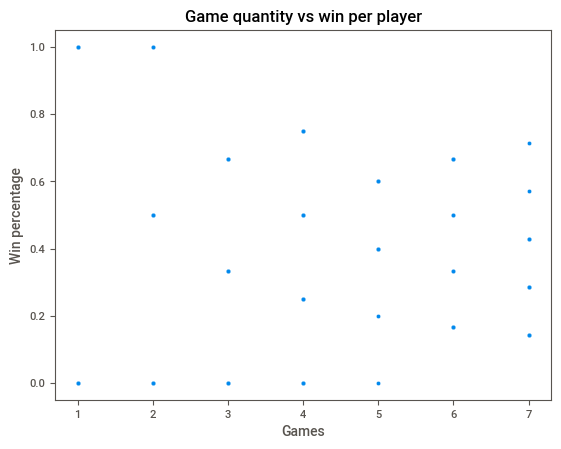

In [167]:
sns.scatterplot(x="counts", y="win_percentage", data=lineup_count)
plt.xlabel("Games")
plt.ylabel("Win percentage")
plt.title("Game quantity vs win per player")
plt.show()

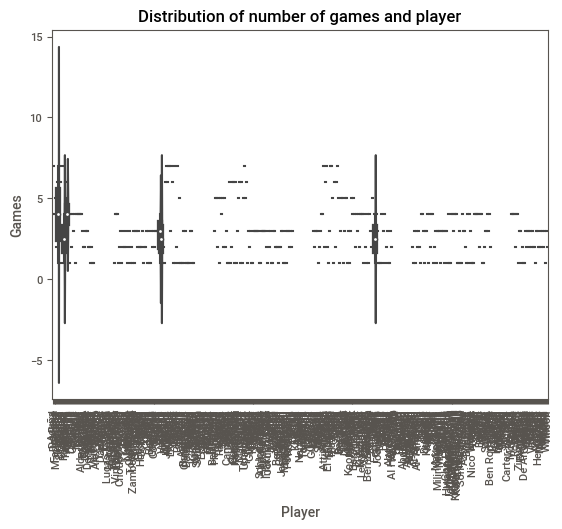

In [166]:
sns.violinplot(x="player", y="counts", data=lineup_count)
plt.xlabel("Player")
plt.ylabel("Games")
plt.title("Distribution of number of games and player")
plt.xticks(rotation=90)
plt.show()

#### Relationship between the number of goals scored and the number of shots on goal

In [43]:
df.columns

Index(['stage', 'date', 'pens', 'pens_home_score', 'pens_away_score',
       'team_name_home', 'team_name_away', 'team_home_score',
       'team_away_score', 'possession_home', 'possession_away',
       'total_shots_home', 'total_shots_away', 'shots_on_target_home',
       'shots_on_target_away', 'duels_won_home', 'duels_won_away',
       'prediction_team_home_win', 'prediction_draw',
       'prediction_team_away_win', 'prediction_quantity', 'location',
       'player_names_home', 'player_numbers_home', 'player_names_away',
       'player_numbers_away', 'who_won', 'prediction', 'upset_case'],
      dtype='object')

In [44]:
columns = [
    "team_name_home",
    "team_name_away",
    "team_home_score",
    "team_away_score",
    "total_shots_home",
    "total_shots_away",
    "shots_on_target_home",
    "shots_on_target_away",
]
df_efetive_goals = df[columns]
df_efetive_goals

,team_name_home,team_name_away,team_home_score,team_away_score,total_shots_home,total_shots_away,shots_on_target_home,shots_on_target_away
0,Argentina,France,3,3,20,10,10,5
1,Croatia,Morocco,2,1,12,9,4,2
2,France,Morocco,2,0,14,13,3,3
3,Argentina,Croatia,3,0,9,12,7,2
4,England,France,1,2,16,8,8,5
...,...,...,...,...,...,...,...,...
59,Argentina,Saudi Arabia,1,2,15,3,6,2
60,USA,Wales,1,1,6,7,1,3
61,Senegal,Netherlands,0,2,15,10,4,3
62,England,Iran,6,2,13,8,7,3


In [45]:
for index, row in df_efetive_goals.iterrows():
    if row.shots_on_target_home != 0:
        df_efetive_goals.loc[
            index, "percentage_goals_per_shots_on_target_home"
        ] = round((row.team_home_score / row.shots_on_target_home), 3)
    else:
        df_efetive_goals.loc[index, "percentage_goals_per_shots_on_target_home"] = 0
    if row.shots_on_target_away != 0:
        df_efetive_goals.loc[
            index, "percentage_goals_per_shots_on_target_away"
        ] = round((row.team_away_score / row.shots_on_target_away), 3)
    else:
        df_efetive_goals.loc[index, "percentage_goals_per_shots_on_target_away"] = 0

In [46]:
grouped_df_efetive_goals = df_efetive_goals.groupby("team_name_home")
mean_df_home = (
    grouped_df_efetive_goals["percentage_goals_per_shots_on_target_home"]
    .mean()
    .reset_index()
)
mean_df_home = mean_df_home.rename(columns={"team_name_home": "team"})
mean_df_home

,team,percentage_goals_per_shots_on_target_home
0,Argentina,0.459200
1,Australia,0.250000
2,Belgium,0.166500
3,Brazil,0.288667
4,Cameroon,0.354000
5,Canada,0.000000
6,Costa Rica,0.333000
7,Croatia,0.475000
8,Denmark,0.000000
9,Ecuador,0.250000


In [47]:
grouped_df_efetive_goals = df_efetive_goals.groupby("team_name_away")
mean_df_away = (
    grouped_df_efetive_goals["percentage_goals_per_shots_on_target_away"]
    .mean()
    .reset_index()
)
mean_df_away = mean_df_away.rename(columns={"team_name_away": "team"})
mean_df_away

,team,percentage_goals_per_shots_on_target_away
0,Argentina,0.283500
1,Australia,0.833333
2,Belgium,0.000000
3,Brazil,0.045500
4,Cameroon,0.000000
5,Canada,0.250000
6,Costa Rica,0.500000
7,Croatia,0.083333
8,Denmark,0.250000
9,Ecuador,0.458500


In [48]:
df_percentage_goals_per_shots_on_target = mean_df_home.merge(mean_df_away)
df_percentage_goals_per_shots_on_target["mean_percentage_goals_per_shots_on_target"] = (
    df_percentage_goals_per_shots_on_target.percentage_goals_per_shots_on_target_away
    + df_percentage_goals_per_shots_on_target.percentage_goals_per_shots_on_target_home
) / 2

df_percentage_goals_per_shots_on_target.sort_values(
    "mean_percentage_goals_per_shots_on_target", ascending=False
)

,team,percentage_goals_per_shots_on_target_home,percentage_goals_per_shots_on_target_away,mean_percentage_goals_per_shots_on_target
18,Netherlands,0.750000,0.667000,0.708500
29,USA,1.000000,0.108333,0.554167
1,Australia,0.250000,0.833333,0.541667
22,Saudi Arabia,0.500000,0.500000,0.500000
10,England,0.433000,0.429000,0.431000
13,Ghana,0.000000,0.833500,0.416750
6,Costa Rica,0.333000,0.500000,0.416500
11,France,0.474750,0.333333,0.404042
15,Japan,0.305667,0.500000,0.402833
24,Serbia,0.500000,0.300000,0.400000


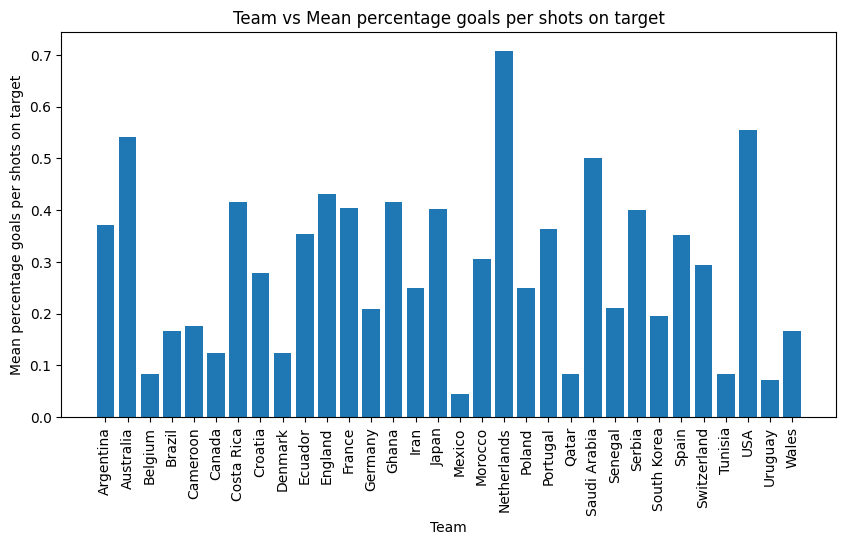

In [49]:
plt.figure(figsize=(10, 5))
plt.bar(
    df_percentage_goals_per_shots_on_target["team"],
    df_percentage_goals_per_shots_on_target[
        "mean_percentage_goals_per_shots_on_target"
    ],
)
plt.xlabel("Team")
plt.ylabel("Mean percentage goals per shots on target")
plt.title("Team vs Mean percentage goals per shots on target")
plt.xticks(rotation=90)
plt.show()

### K-means cluster with prediction columns

In [16]:
events_list = pd.read_csv("datasets/df_events_list.csv").drop(
    ["event_team", "event_time"], axis=1
)
events_list.shape

(1043, 4)

In [17]:
events_list.columns

Index(['team', 'event_type', 'action_player_1', 'action_player_2'], dtype='object')

In [18]:
events_list.dtypes

team               object
event_type         object
action_player_1    object
action_player_2    object
dtype: object

In [19]:
# converting string object to numerical values using onehot encoder
dummies = ["team", "event_type", "action_player_1", "action_player_2"]

encoded_data = pd.get_dummies(events_list[dummies])
events_list = pd.concat([events_list, encoded_data], axis=1).drop(dummies, axis=1)

In [20]:
events_list

,team_Argentina,team_Australia,team_Belgium,team_Brazil,team_Cameroon,team_Canada,team_Costa Rica,team_Croatia,team_Denmark,team_Ecuador,...,action_player_2_ Youssef En-Nesyri,action_player_2_ Youssef Msakni,action_player_2_ Youssouf Fofana,action_player_2_ Yuki Soma,action_player_2_ Yunus Musah,action_player_2_ Yuto Nagatomo,action_player_2_ Álvaro Morata,action_player_2_ Ángel Di María,action_player_2_ Ángelo Preciado,action_player_2_ Éder Militão
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1038,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1039,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1040,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1041,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [22]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(events_list)

predictions = kmeans.predict(events_list)
events_list["prediction_cluster"] = predictions

In [24]:
print(predictions)

[0 0 1 ... 3 1 1]


In [50]:
X = df[["prediction_team_home_win", "prediction_draw", "prediction_team_away_win"]]

kmeans = KMeans(n_clusters=3)
kmeans.fit(X)

predictions = kmeans.predict(X)
df["prediction_cluster"] = predictions

In [51]:
df[
    [
        "prediction_team_home_win",
        "prediction_draw",
        "prediction_team_away_win",
        "prediction_cluster",
    ]
]

,prediction_team_home_win,prediction_draw,prediction_team_away_win,prediction_cluster
0,0.64,0.03,0.33,2
1,0.42,0.04,0.54,2
2,0.58,0.03,0.39,2
3,0.71,0.04,0.25,0
4,0.40,0.05,0.55,2
...,...,...,...,...
59,0.94,0.02,0.04,0
60,0.51,0.09,0.40,2
61,0.22,0.07,0.71,1
62,0.92,0.02,0.06,0


In [52]:
X = df[
    [
        "possession_home",
        "possession_away",
        "total_shots_home",
        "total_shots_away",
        "shots_on_target_home",
        "shots_on_target_away",
        "duels_won_home",
        "duels_won_away",
    ]
]

kmeans = KMeans(n_clusters=4)

kmeans.fit(X)

predictions = kmeans.predict(X)

df["game_cluster"] = predictions

df[
    [
        "possession_home",
        "possession_away",
        "total_shots_home",
        "total_shots_away",
        "shots_on_target_home",
        "shots_on_target_away",
        "duels_won_home",
        "duels_won_away",
        "game_cluster",
    ]
]

,possession_home,possession_away,total_shots_home,total_shots_away,shots_on_target_home,shots_on_target_away,duels_won_home,duels_won_away,game_cluster
0,0.54,0.46,20,10,10,5,0.40,0.60,0
1,0.51,0.49,12,9,4,2,0.53,0.47,2
2,0.38,0.62,14,13,3,3,0.58,0.42,1
3,0.39,0.61,9,12,7,2,0.43,0.57,1
4,0.58,0.42,16,8,8,5,0.55,0.45,0
...,...,...,...,...,...,...,...,...,...
59,0.70,0.30,15,3,6,2,0.64,0.36,0
60,0.59,0.41,6,7,1,3,0.47,0.54,2
61,0.46,0.54,15,10,4,3,0.54,0.47,2
62,0.79,0.21,13,8,7,3,0.60,0.40,2


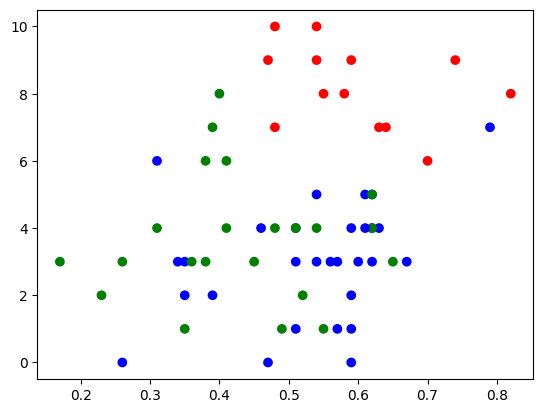

In [53]:
x = df["possession_home"]
y = df["shots_on_target_home"]

colors = [
    "red" if x == 0 else "green" if x == 1 else "blue" for x in df["game_cluster"]
]

# Plot
plt.scatter(x, y, c=colors)
plt.show()

In [54]:
df_events_list

,team,event_team,event_time,event_type,action_player_1,action_player_2
0,Argentina,home,23',Penalty,Lionel Messi,Penalty
1,Argentina,home,36',Goal,Ángel Di María,Alexis Mac Allister
2,France,away,41',Substitution,Randal Kolo Muani,Ousmane Dembélé
3,France,away,41',Substitution,Marcus Thuram,Olivier Giroud
4,Argentina,home,52',Yellow card,Enzo Fernández,None
...,...,...,...,...,...,...
1038,Qatar,home,72',Substitution,Mohammed Muntari,Almoez Ali
1039,Ecuador,away,77',Substitution,José Cifuentes,Enner Valencia
1040,Qatar,home,78',Yellow card,Akram Afif,None
1041,Ecuador,away,90',Substitution,Kevin Rodríguez,Michael Estrada


#### Previsions using ML Algorithms

separar o dataset em treino e teste antes de fazer qualquer preprocessamento

##### Random Forest

In [133]:
df.columns

Index(['stage', 'date', 'pens', 'pens_home_score', 'pens_away_score',
       'team_name_home', 'team_name_away', 'team_home_score',
       'team_away_score', 'possession_home', 'possession_away',
       'total_shots_home', 'total_shots_away', 'shots_on_target_home',
       'shots_on_target_away', 'duels_won_home', 'duels_won_away',
       'prediction_team_home_win', 'prediction_draw',
       'prediction_team_away_win', 'prediction_quantity', 'location',
       'events_list', 'lineup_home', 'lineup_away'],
      dtype='object')

In [134]:
columns = [
    "team_name_home",
    "team_name_away",
    "prediction_team_home_win",
    "prediction_draw",
    "prediction_team_away_win",
]
df_ml = df[columns]
df_ml

,team_name_home,team_name_away,prediction_team_home_win,prediction_draw,prediction_team_away_win
0,Argentina,France,0.64,0.03,0.33
1,Croatia,Morocco,0.42,0.04,0.54
2,France,Morocco,0.58,0.03,0.39
3,Argentina,Croatia,0.71,0.04,0.25
4,England,France,0.40,0.05,0.55
...,...,...,...,...,...
59,Argentina,Saudi Arabia,0.94,0.02,0.04
60,USA,Wales,0.51,0.09,0.40
61,Senegal,Netherlands,0.22,0.07,0.71
62,England,Iran,0.92,0.02,0.06


In [135]:
x_features = ["team_name_home", "team_name_away"]
y_features = ["prediction_team_home_win", "prediction_draw", "prediction_team_away_win"]

X = df_ml[x_features]
y = df_ml[y_features]

In [136]:
# categorical values to numerical values
X = pd.get_dummies(X, columns=["team_name_home", "team_name_away"])

In [137]:
# split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"X_train.shape: \t{X_train.shape}")
print(f"y_train.shape: \t{y_train.shape}")
print(f"X_test.shape: \t{X_test.shape}")
print(f"y_test.shape: \t{y_test.shape}")

X_train.shape: 	(51, 64)
y_train.shape: 	(51, 3)
X_test.shape: 	(13, 64)
y_test.shape: 	(13, 3)


In [124]:
# Create the Random Forest Regressor
regr = RandomForestRegressor()

# Define the parameter grid for grid search
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 5, 10],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["auto", "sqrt"],
}

# Create the kfold cross-validator
kf = KFold(n_splits=5, shuffle=True)

# Perform grid search with kfold cv
grid_search = GridSearchCV(regr, param_grid, cv=kf)
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print(grid_search.best_params_)
print(grid_search.best_score_)

{'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 50}
0.015262012501058825


In [125]:
clf = RandomForestRegressor(**grid_search.best_params_, random_state=42)

In [126]:
clf.fit(X_train, y_train)

RandomForestRegressor(max_depth=5, max_features='auto', min_samples_leaf=2,
                      min_samples_split=10, n_estimators=50, random_state=42)

In [127]:
y_pred = clf.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("Mean squared error: ", mse)

Mean squared error:  0.03394332234550271


#### Predictions of the home team winning, drawing or away team winning

##### Using RandomForestClassifier

In [240]:
# Reload df
df = pd.read_csv("world_cup_2022_catar.csv")

clean_percentage_columns(
    df,
    [
        "possession_home",
        "possession_away",
        "duels_won_home",
        "duels_won_away",
        "prediction_team_home_win",
        "prediction_draw",
        "prediction_team_away_win",
        "prediction_quantity",
    ],
)

,stage,date,pens,pens_home_score,pens_away_score,team_name_home,team_name_away,team_home_score,team_away_score,possession_home,...,duels_won_home,duels_won_away,prediction_team_home_win,prediction_draw,prediction_team_away_win,prediction_quantity,location,events_list,lineup_home,lineup_away
0,Final,18/12/2022,True,4,2,Argentina,France,3,3,0.54,...,0.40,0.60,0.64,0.03,0.33,10023.32,Lusail Iconic Stadium,"[{'event_team': 'home', 'event_time': "" 23' "",...","[{'player_name': ' Di María ', 'player_number'...","[{'player_name': ' Giroud ', 'player_number': ..."
1,Match for third place,17/12/2022,False,False,False,Croatia,Morocco,2,1,0.51,...,0.53,0.47,0.42,0.04,0.54,3671.56,Khalifa International Stadium,"[{'event_team': 'home', 'event_time': "" 7' "", ...","[{'player_name': ' Livaja ', 'player_number': ...","[{'player_name': ' Boufal ', 'player_number': ..."
2,Semi-finals,14/12/2022,False,False,False,France,Morocco,2,0,0.38,...,0.58,0.42,0.58,0.03,0.39,7207.68,Al Bayt Stadium,"[{'event_team': 'home', 'event_time': "" 5' "", ...","[{'player_name': ' Giroud ', 'player_number': ...","[{'player_name': ' En-Nesyri ', 'player_number..."
3,Semi-finals,13/12/2022,False,False,False,Argentina,Croatia,3,0,0.39,...,0.43,0.57,0.71,0.04,0.25,7923.26,Lusail Iconic Stadium,"[{'event_team': 'away', 'event_time': "" 32' "",...","[{'player_name': ' Álvarez ', 'player_number':...","[{'player_name': ' Perišić ', 'player_number':..."
4,Quarter-finals,10/12/2022,False,False,False,England,France,1,2,0.58,...,0.55,0.45,0.40,0.05,0.55,6725.77,Al Bayt Stadium,"[{'event_team': 'away', 'event_time': "" 17' "",...","[{'player_name': ' Foden ', 'player_number': '...","[{'player_name': ' Giroud ', 'player_number': ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,Group stage: Matchday 1,22/11/2022,False,False,False,Argentina,Saudi Arabia,1,2,0.70,...,0.64,0.36,0.94,0.02,0.04,6573.83,Lusail Iconic Stadium,"[{'event_team': 'home', 'event_time': "" 10' "",...","[{'player_name': ' Martínez ', 'player_number'...","[{'player_name': ' Al-Shehri ', 'player_number..."
60,Group stage: Matchday 1,21/11/2022,False,False,False,USA,Wales,1,1,0.59,...,0.47,0.54,0.51,0.09,0.40,3611.45,Ahmad bin Ali Stadium,"[{'event_team': 'home', 'event_time': "" 11' "",...","[{'player_name': ' Pulisic ', 'player_number':...","[{'player_name': ' James ', 'player_number': '..."
61,Group stage: Matchday 1,21/11/2022,False,False,False,Senegal,Netherlands,0,2,0.46,...,0.54,0.47,0.22,0.07,0.71,4579.77,Al Thumama Stadium,"[{'event_team': 'away', 'event_time': "" 56' "",...","[{'player_name': ' Dia ', 'player_number': ' 9...","[{'player_name': ' Bergwijn ', 'player_number'..."
62,Group stage: Matchday 1,21/11/2022,False,False,False,England,Iran,6,2,0.79,...,0.60,0.40,0.92,0.02,0.06,4987.52,Khalifa International Stadium,"[{'event_team': 'away', 'event_time': "" 20' "",...","[{'player_name': ' Kane ', 'player_number': ' ...","[{'player_name': ' Taremi ', 'player_number': ..."


In [241]:
for index, row in df.iterrows():
    if row.pens == True:
        if row.pens_home_score > row.pens_away_score:
            df.loc[index, "who_won"] = "team_home_winning"
        else:
            df.loc[index, "who_won"] = "team_away_winning"
    else:
        if row.team_home_score > row.team_away_score:
            df.loc[index, "who_won"] = "team_home_winning"
        elif row.team_home_score < row.team_away_score:
            df.loc[index, "who_won"] = "team_away_winning"
        else:
            df.loc[index, "who_won"] = "Draw"

In [242]:
X = df[
    [
        "team_home_score",
        "team_away_score",
        "possession_home",
        "possession_away",
        "total_shots_home",
        "total_shots_away",
        "shots_on_target_home",
        "shots_on_target_away",
        "duels_won_home",
        "duels_won_away",
    ]
]
y = df["who_won"]

In [243]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"X_train.shape: \t{X_train.shape}")
print(f"y_train.shape: \t{y_train.shape}")
print(f"X_test.shape: \t{X_test.shape}")
print(f"y_test.shape: \t{y_test.shape}")

X_train.shape: 	(51, 10)
y_train.shape: 	(51,)
X_test.shape: 	(13, 10)
y_test.shape: 	(13,)


In [244]:
# Create the Random Forest Regressor
clf = RandomForestClassifier()

# Define the parameter grid for grid search
param_grid = {
    "n_estimators": [10, 50, 100],
    "max_depth": [2, 5, 10],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
}

# Create the kfold cross-validator
kf = KFold(n_splits=5, shuffle=True)

# Perform grid search with kfold cv
grid_search = GridSearchCV(clf, param_grid, cv=kf)
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print(grid_search.best_params_)
print(grid_search.best_score_)

{'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
0.8236363636363636


In [245]:
clf = RandomForestClassifier(**grid_search.best_params_, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, random_state=42)

In [246]:
y_pred = clf.predict(X_test)
y_pred

array(['team_home_winning', 'Draw', 'team_away_winning', 'Draw',
       'team_home_winning', 'team_away_winning', 'team_away_winning',
       'team_home_winning', 'team_away_winning', 'team_away_winning',
       'team_home_winning', 'Draw', 'team_home_winning'], dtype=object)

In [237]:
X_test["predictions"] = y_pred
X_test

,team_home_score,team_away_score,possession_home,possession_away,total_shots_home,total_shots_away,shots_on_target_home,shots_on_target_away,duels_won_home,duels_won_away,predictions
52,1,0,0.54,0.46,9,22,3,3,0.57,0.43,team_home_winning
58,0,0,0.62,0.38,11,13,5,1,0.44,0.56,Draw
0,3,3,0.54,0.46,20,10,10,5,0.40,0.60,team_away_winning
44,0,0,0.56,0.44,8,10,3,1,0.52,0.48,Draw
5,1,0,0.26,0.74,9,12,3,3,0.48,0.52,team_home_winning
36,1,1,0.65,0.35,7,11,3,4,0.43,0.57,team_away_winning
16,2,3,0.54,0.46,12,14,4,7,0.52,0.48,team_away_winning
12,3,0,0.62,0.38,8,10,4,1,0.51,0.50,team_home_winning
25,0,2,0.26,0.74,4,23,0,12,0.49,0.51,team_away_winning
61,0,2,0.46,0.54,15,10,4,3,0.54,0.47,team_away_winning


In [247]:
accuracy_clf = accuracy_score(y_test, y_pred)
precision_clf = precision_score(y_test, y_pred, average="micro")
recall_clf = recall_score(y_test, y_pred, average="micro")
f1_clf = f1_score(y_test, y_pred, average="micro")
print("Accuracy:", accuracy_clf)
print("Precision: ", precision_clf)
print("Recall: ", recall_clf)
print("F1-Score: ", f1_clf)
print(classification_report(y_test, y_pred))

Accuracy: 0.7692307692307693
Precision:  0.7692307692307693
Recall:  0.7692307692307693
F1-Score:  0.7692307692307693
                   precision    recall  f1-score   support

             Draw       0.67      0.67      0.67         3
team_away_winning       0.60      1.00      0.75         3
team_home_winning       1.00      0.71      0.83         7

         accuracy                           0.77        13
        macro avg       0.76      0.79      0.75        13
     weighted avg       0.83      0.77      0.78        13



##### Using SVM

In [248]:
# Reload df
df = pd.read_csv("world_cup_2022_catar.csv")

clean_percentage_columns(
    df,
    [
        "possession_home",
        "possession_away",
        "duels_won_home",
        "duels_won_away",
        "prediction_team_home_win",
        "prediction_draw",
        "prediction_team_away_win",
        "prediction_quantity",
    ],
)

,stage,date,pens,pens_home_score,pens_away_score,team_name_home,team_name_away,team_home_score,team_away_score,possession_home,...,duels_won_home,duels_won_away,prediction_team_home_win,prediction_draw,prediction_team_away_win,prediction_quantity,location,events_list,lineup_home,lineup_away
0,Final,18/12/2022,True,4,2,Argentina,France,3,3,0.54,...,0.40,0.60,0.64,0.03,0.33,10023.32,Lusail Iconic Stadium,"[{'event_team': 'home', 'event_time': "" 23' "",...","[{'player_name': ' Di María ', 'player_number'...","[{'player_name': ' Giroud ', 'player_number': ..."
1,Match for third place,17/12/2022,False,False,False,Croatia,Morocco,2,1,0.51,...,0.53,0.47,0.42,0.04,0.54,3671.56,Khalifa International Stadium,"[{'event_team': 'home', 'event_time': "" 7' "", ...","[{'player_name': ' Livaja ', 'player_number': ...","[{'player_name': ' Boufal ', 'player_number': ..."
2,Semi-finals,14/12/2022,False,False,False,France,Morocco,2,0,0.38,...,0.58,0.42,0.58,0.03,0.39,7207.68,Al Bayt Stadium,"[{'event_team': 'home', 'event_time': "" 5' "", ...","[{'player_name': ' Giroud ', 'player_number': ...","[{'player_name': ' En-Nesyri ', 'player_number..."
3,Semi-finals,13/12/2022,False,False,False,Argentina,Croatia,3,0,0.39,...,0.43,0.57,0.71,0.04,0.25,7923.26,Lusail Iconic Stadium,"[{'event_team': 'away', 'event_time': "" 32' "",...","[{'player_name': ' Álvarez ', 'player_number':...","[{'player_name': ' Perišić ', 'player_number':..."
4,Quarter-finals,10/12/2022,False,False,False,England,France,1,2,0.58,...,0.55,0.45,0.40,0.05,0.55,6725.77,Al Bayt Stadium,"[{'event_team': 'away', 'event_time': "" 17' "",...","[{'player_name': ' Foden ', 'player_number': '...","[{'player_name': ' Giroud ', 'player_number': ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,Group stage: Matchday 1,22/11/2022,False,False,False,Argentina,Saudi Arabia,1,2,0.70,...,0.64,0.36,0.94,0.02,0.04,6573.83,Lusail Iconic Stadium,"[{'event_team': 'home', 'event_time': "" 10' "",...","[{'player_name': ' Martínez ', 'player_number'...","[{'player_name': ' Al-Shehri ', 'player_number..."
60,Group stage: Matchday 1,21/11/2022,False,False,False,USA,Wales,1,1,0.59,...,0.47,0.54,0.51,0.09,0.40,3611.45,Ahmad bin Ali Stadium,"[{'event_team': 'home', 'event_time': "" 11' "",...","[{'player_name': ' Pulisic ', 'player_number':...","[{'player_name': ' James ', 'player_number': '..."
61,Group stage: Matchday 1,21/11/2022,False,False,False,Senegal,Netherlands,0,2,0.46,...,0.54,0.47,0.22,0.07,0.71,4579.77,Al Thumama Stadium,"[{'event_team': 'away', 'event_time': "" 56' "",...","[{'player_name': ' Dia ', 'player_number': ' 9...","[{'player_name': ' Bergwijn ', 'player_number'..."
62,Group stage: Matchday 1,21/11/2022,False,False,False,England,Iran,6,2,0.79,...,0.60,0.40,0.92,0.02,0.06,4987.52,Khalifa International Stadium,"[{'event_team': 'away', 'event_time': "" 20' "",...","[{'player_name': ' Kane ', 'player_number': ' ...","[{'player_name': ' Taremi ', 'player_number': ..."


In [249]:
for index, row in df.iterrows():
    if row.pens == True:
        if row.pens_home_score > row.pens_away_score:
            df.loc[index, "who_won"] = "team_home_winning"
        else:
            df.loc[index, "who_won"] = "team_away_winning"
    else:
        if row.team_home_score > row.team_away_score:
            df.loc[index, "who_won"] = "team_home_winning"
        elif row.team_home_score < row.team_away_score:
            df.loc[index, "who_won"] = "team_away_winning"
        else:
            df.loc[index, "who_won"] = "Draw"

In [250]:
X = df[
    [
        "team_home_score",
        "team_away_score",
        "possession_home",
        "possession_away",
        "total_shots_home",
        "total_shots_away",
        "shots_on_target_home",
        "shots_on_target_away",
        "duels_won_home",
        "duels_won_away",
    ]
]
y = df["who_won"]

In [251]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"X_train.shape: \t{X_train.shape}")
print(f"y_train.shape: \t{y_train.shape}")
print(f"X_test.shape: \t{X_test.shape}")
print(f"y_test.shape: \t{y_test.shape}")

X_train.shape: 	(51, 10)
y_train.shape: 	(51,)
X_test.shape: 	(13, 10)
y_test.shape: 	(13,)


In [252]:
# Create the Random Forest Regressor
svm = SVC()

# Define the parameter grid for grid search
param_grid = {
    "C": [0.1, 1, 10],
    "kernel": ["linear", "poly", "rbf"],
    "degree": [2, 3, 4],
    "gamma": ["scale", "auto"],
}

# Create the kfold cross-validator
kf = KFold(n_splits=5, shuffle=True)

# Perform grid search with kfold cv
grid_search = GridSearchCV(svm, param_grid, cv=kf)
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print(grid_search.best_params_)
print(grid_search.best_score_)

{'C': 10, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}
0.901818181818182


In [253]:
svm = SVC(**grid_search.best_params_, random_state=42)
svm.fit(X_train, y_train)

SVC(C=10, degree=2, kernel='linear', random_state=42)

In [254]:
y_pred = svm.predict(X_test)
y_pred

array(['Draw', 'Draw', 'team_away_winning', 'Draw', 'team_home_winning',
       'Draw', 'team_away_winning', 'team_home_winning',
       'team_away_winning', 'team_away_winning', 'team_home_winning',
       'Draw', 'team_home_winning'], dtype=object)

In [255]:
X_test["predictions"] = y_pred
X_test

,team_home_score,team_away_score,possession_home,possession_away,total_shots_home,total_shots_away,shots_on_target_home,shots_on_target_away,duels_won_home,duels_won_away,predictions
52,1,0,0.54,0.46,9,22,3,3,0.57,0.43,Draw
58,0,0,0.62,0.38,11,13,5,1,0.44,0.56,Draw
0,3,3,0.54,0.46,20,10,10,5,0.40,0.60,team_away_winning
44,0,0,0.56,0.44,8,10,3,1,0.52,0.48,Draw
5,1,0,0.26,0.74,9,12,3,3,0.48,0.52,team_home_winning
36,1,1,0.65,0.35,7,11,3,4,0.43,0.57,Draw
16,2,3,0.54,0.46,12,14,4,7,0.52,0.48,team_away_winning
12,3,0,0.62,0.38,8,10,4,1,0.51,0.50,team_home_winning
25,0,2,0.26,0.74,4,23,0,12,0.49,0.51,team_away_winning
61,0,2,0.46,0.54,15,10,4,3,0.54,0.47,team_away_winning


In [256]:
accuracy_svm = accuracy_score(y_test, y_pred)
precision_svm = precision_score(y_test, y_pred, average="micro")
recall_svm = recall_score(y_test, y_pred, average="micro")
f1_svm = f1_score(y_test, y_pred, average="micro")
print("Accuracy:", accuracy_svm)
print("Precision: ", precision_svm)
print("Recall: ", recall_svm)
print("F1-Score: ", f1_svm)
print(classification_report(y_test, y_pred))

Accuracy: 0.7692307692307693
Precision:  0.7692307692307693
Recall:  0.7692307692307693
F1-Score:  0.7692307692307693
                   precision    recall  f1-score   support

             Draw       0.60      1.00      0.75         3
team_away_winning       0.75      1.00      0.86         3
team_home_winning       1.00      0.57      0.73         7

         accuracy                           0.77        13
        macro avg       0.78      0.86      0.78        13
     weighted avg       0.85      0.77      0.76        13



##### Using LogisticRegression

In [259]:
# Reload df
df = pd.read_csv("world_cup_2022_catar.csv")

clean_percentage_columns(
    df,
    [
        "possession_home",
        "possession_away",
        "duels_won_home",
        "duels_won_away",
        "prediction_team_home_win",
        "prediction_draw",
        "prediction_team_away_win",
        "prediction_quantity",
    ],
)

,stage,date,pens,pens_home_score,pens_away_score,team_name_home,team_name_away,team_home_score,team_away_score,possession_home,...,duels_won_home,duels_won_away,prediction_team_home_win,prediction_draw,prediction_team_away_win,prediction_quantity,location,events_list,lineup_home,lineup_away
0,Final,18/12/2022,True,4,2,Argentina,France,3,3,0.54,...,0.40,0.60,0.64,0.03,0.33,10023.32,Lusail Iconic Stadium,"[{'event_team': 'home', 'event_time': "" 23' "",...","[{'player_name': ' Di María ', 'player_number'...","[{'player_name': ' Giroud ', 'player_number': ..."
1,Match for third place,17/12/2022,False,False,False,Croatia,Morocco,2,1,0.51,...,0.53,0.47,0.42,0.04,0.54,3671.56,Khalifa International Stadium,"[{'event_team': 'home', 'event_time': "" 7' "", ...","[{'player_name': ' Livaja ', 'player_number': ...","[{'player_name': ' Boufal ', 'player_number': ..."
2,Semi-finals,14/12/2022,False,False,False,France,Morocco,2,0,0.38,...,0.58,0.42,0.58,0.03,0.39,7207.68,Al Bayt Stadium,"[{'event_team': 'home', 'event_time': "" 5' "", ...","[{'player_name': ' Giroud ', 'player_number': ...","[{'player_name': ' En-Nesyri ', 'player_number..."
3,Semi-finals,13/12/2022,False,False,False,Argentina,Croatia,3,0,0.39,...,0.43,0.57,0.71,0.04,0.25,7923.26,Lusail Iconic Stadium,"[{'event_team': 'away', 'event_time': "" 32' "",...","[{'player_name': ' Álvarez ', 'player_number':...","[{'player_name': ' Perišić ', 'player_number':..."
4,Quarter-finals,10/12/2022,False,False,False,England,France,1,2,0.58,...,0.55,0.45,0.40,0.05,0.55,6725.77,Al Bayt Stadium,"[{'event_team': 'away', 'event_time': "" 17' "",...","[{'player_name': ' Foden ', 'player_number': '...","[{'player_name': ' Giroud ', 'player_number': ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,Group stage: Matchday 1,22/11/2022,False,False,False,Argentina,Saudi Arabia,1,2,0.70,...,0.64,0.36,0.94,0.02,0.04,6573.83,Lusail Iconic Stadium,"[{'event_team': 'home', 'event_time': "" 10' "",...","[{'player_name': ' Martínez ', 'player_number'...","[{'player_name': ' Al-Shehri ', 'player_number..."
60,Group stage: Matchday 1,21/11/2022,False,False,False,USA,Wales,1,1,0.59,...,0.47,0.54,0.51,0.09,0.40,3611.45,Ahmad bin Ali Stadium,"[{'event_team': 'home', 'event_time': "" 11' "",...","[{'player_name': ' Pulisic ', 'player_number':...","[{'player_name': ' James ', 'player_number': '..."
61,Group stage: Matchday 1,21/11/2022,False,False,False,Senegal,Netherlands,0,2,0.46,...,0.54,0.47,0.22,0.07,0.71,4579.77,Al Thumama Stadium,"[{'event_team': 'away', 'event_time': "" 56' "",...","[{'player_name': ' Dia ', 'player_number': ' 9...","[{'player_name': ' Bergwijn ', 'player_number'..."
62,Group stage: Matchday 1,21/11/2022,False,False,False,England,Iran,6,2,0.79,...,0.60,0.40,0.92,0.02,0.06,4987.52,Khalifa International Stadium,"[{'event_team': 'away', 'event_time': "" 20' "",...","[{'player_name': ' Kane ', 'player_number': ' ...","[{'player_name': ' Taremi ', 'player_number': ..."


In [260]:
for index, row in df.iterrows():
    if row.pens == True:
        if row.pens_home_score > row.pens_away_score:
            df.loc[index, "who_won"] = "team_home_winning"
        else:
            df.loc[index, "who_won"] = "team_away_winning"
    else:
        if row.team_home_score > row.team_away_score:
            df.loc[index, "who_won"] = "team_home_winning"
        elif row.team_home_score < row.team_away_score:
            df.loc[index, "who_won"] = "team_away_winning"
        else:
            df.loc[index, "who_won"] = "Draw"

In [261]:
X = df[
    [
        "team_home_score",
        "team_away_score",
        "possession_home",
        "possession_away",
        "total_shots_home",
        "total_shots_away",
        "shots_on_target_home",
        "shots_on_target_away",
        "duels_won_home",
        "duels_won_away",
    ]
]
y = df["who_won"]

In [262]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"X_train.shape: \t{X_train.shape}")
print(f"y_train.shape: \t{y_train.shape}")
print(f"X_test.shape: \t{X_test.shape}")
print(f"y_test.shape: \t{y_test.shape}")

X_train.shape: 	(51, 10)
y_train.shape: 	(51,)
X_test.shape: 	(13, 10)
y_test.shape: 	(13,)


In [263]:
# Create the Random Forest Regressor
logreg = LogisticRegression()

# Define the parameter grid for grid search
param_grid = {"C": [0.1, 1, 10], "penalty": ["l1", "l2"]}

# Create the kfold cross-validator
kf = KFold(n_splits=5, shuffle=True)

# Perform grid search with kfold cv
grid_search = GridSearchCV(logreg, param_grid, cv=kf)
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print(grid_search.best_params_)
print(grid_search.best_score_)

{'C': 10, 'penalty': 'l2'}
0.8799999999999999


In [264]:
logreg = LogisticRegression(**grid_search.best_params_, random_state=42)
logreg.fit(X_train, y_train)

LogisticRegression(C=10, random_state=42)

In [265]:
y_pred = logreg.predict(X_test)
y_pred

array(['team_home_winning', 'Draw', 'team_home_winning', 'Draw',
       'team_home_winning', 'Draw', 'team_away_winning',
       'team_home_winning', 'team_away_winning', 'team_away_winning',
       'team_home_winning', 'Draw', 'team_home_winning'], dtype=object)

In [266]:
X_test["predictions"] = y_pred
X_test

,team_home_score,team_away_score,possession_home,possession_away,total_shots_home,total_shots_away,shots_on_target_home,shots_on_target_away,duels_won_home,duels_won_away,predictions
52,1,0,0.54,0.46,9,22,3,3,0.57,0.43,team_home_winning
58,0,0,0.62,0.38,11,13,5,1,0.44,0.56,Draw
0,3,3,0.54,0.46,20,10,10,5,0.40,0.60,team_home_winning
44,0,0,0.56,0.44,8,10,3,1,0.52,0.48,Draw
5,1,0,0.26,0.74,9,12,3,3,0.48,0.52,team_home_winning
36,1,1,0.65,0.35,7,11,3,4,0.43,0.57,Draw
16,2,3,0.54,0.46,12,14,4,7,0.52,0.48,team_away_winning
12,3,0,0.62,0.38,8,10,4,1,0.51,0.50,team_home_winning
25,0,2,0.26,0.74,4,23,0,12,0.49,0.51,team_away_winning
61,0,2,0.46,0.54,15,10,4,3,0.54,0.47,team_away_winning


In [267]:
accuracy_logreg = accuracy_score(y_test, y_pred)
precision_logreg = precision_score(y_test, y_pred, average="micro")
recall_logreg = recall_score(y_test, y_pred, average="micro")
f1_logreg = f1_score(y_test, y_pred, average="micro")
print("Accuracy:", accuracy_svm)
print("Precision: ", precision_svm)
print("Recall: ", recall_svm)
print("F1-Score: ", f1_svm)
print(classification_report(y_test, y_pred))

Accuracy: 0.7692307692307693
Precision:  0.7692307692307693
Recall:  0.7692307692307693
F1-Score:  0.7692307692307693
                   precision    recall  f1-score   support

             Draw       0.75      1.00      0.86         3
team_away_winning       1.00      1.00      1.00         3
team_home_winning       1.00      0.86      0.92         7

         accuracy                           0.92        13
        macro avg       0.92      0.95      0.93        13
     weighted avg       0.94      0.92      0.93        13

